# Projet de Machine Learning 
## Gym Members Exercise Dataset
### EHRHART Elsa, SLISSE Paul, STAUB Guillaume, HOSSEINI Arman
(Notebook R)

In [1]:
library(ggplot2)
library(gridExtra)
library(liver)
library(repr)
library(tidyverse)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attachement du package : 'plotly'


L'objet suivant est masqué depuis 'package:ggplot2':

    last_plot


L'objet suivant est masqué depuis 'package:stats':

    filter


L'objet suivant est masqué depuis 'package:graphics':

    layout


corrplot 0.94 loaded


Attachement du package : 'r

### I. Analyse exploratoire



#### 1.Importation des données

In [2]:
path <- "./gym_members_exercise_tracking.csv"
gym <- read.table(path,sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(gym)
# Vérification du contenu
summary(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

#### 2.Nature, encodage et nettoyage des données

In [3]:
#On change les variables qualitatives en facteur
gym["Gender"]<-as.factor(gym[,"Gender"])
gym["Workout_Type"]<-as.factor(gym[,"Workout_Type"])
gym["Experience_Level"]<-as.factor(gym[,"Experience_Level"])

Les seules variables qualitatives sont $Gender$ et $Workout\_Type$. Nous avons également modifié la variable $Experience\_Level$ en facteur alors que c'est considéré comme une variable quantitative discrète car le nombre de valeurs prises et petites (3) et qu'il nous semble plus judicieux de donner un coefficient pour chaque niveau d'expérience plutôt que pour l'expérience au global. Cela nous permettra également par la suite de plus facilement faire de la classification sur cette variable. Nous avons décidé de conserver la variable $Workout\_Frequency..days.week.$ en quantitative discrète car nous pensons qu'il est plus judicieux de donner un coefficient global pour la variable que pour chaque modalité, le nombre de jour exact étant moins important que la différence de jours entre 2 individus.

In [4]:
# Vérification dans le summary
summary(gym)

      Age           Gender     Weight..kg.       Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   : 40.00   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.: 58.10   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median : 70.00   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   : 73.85   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.: 86.00   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :129.90   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0

In [5]:
find.na(gym)

[1] " No missing values (NA) in the dataset."


Notre jeu de données ne contient aucune valeur manquante, on va pouvoir continuer l'analyse en utilisant l'ensemble du jeu de données.
Nous allons maintenant regarder la distribution des variables.

#### 3.Analyse unidimensionelle

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


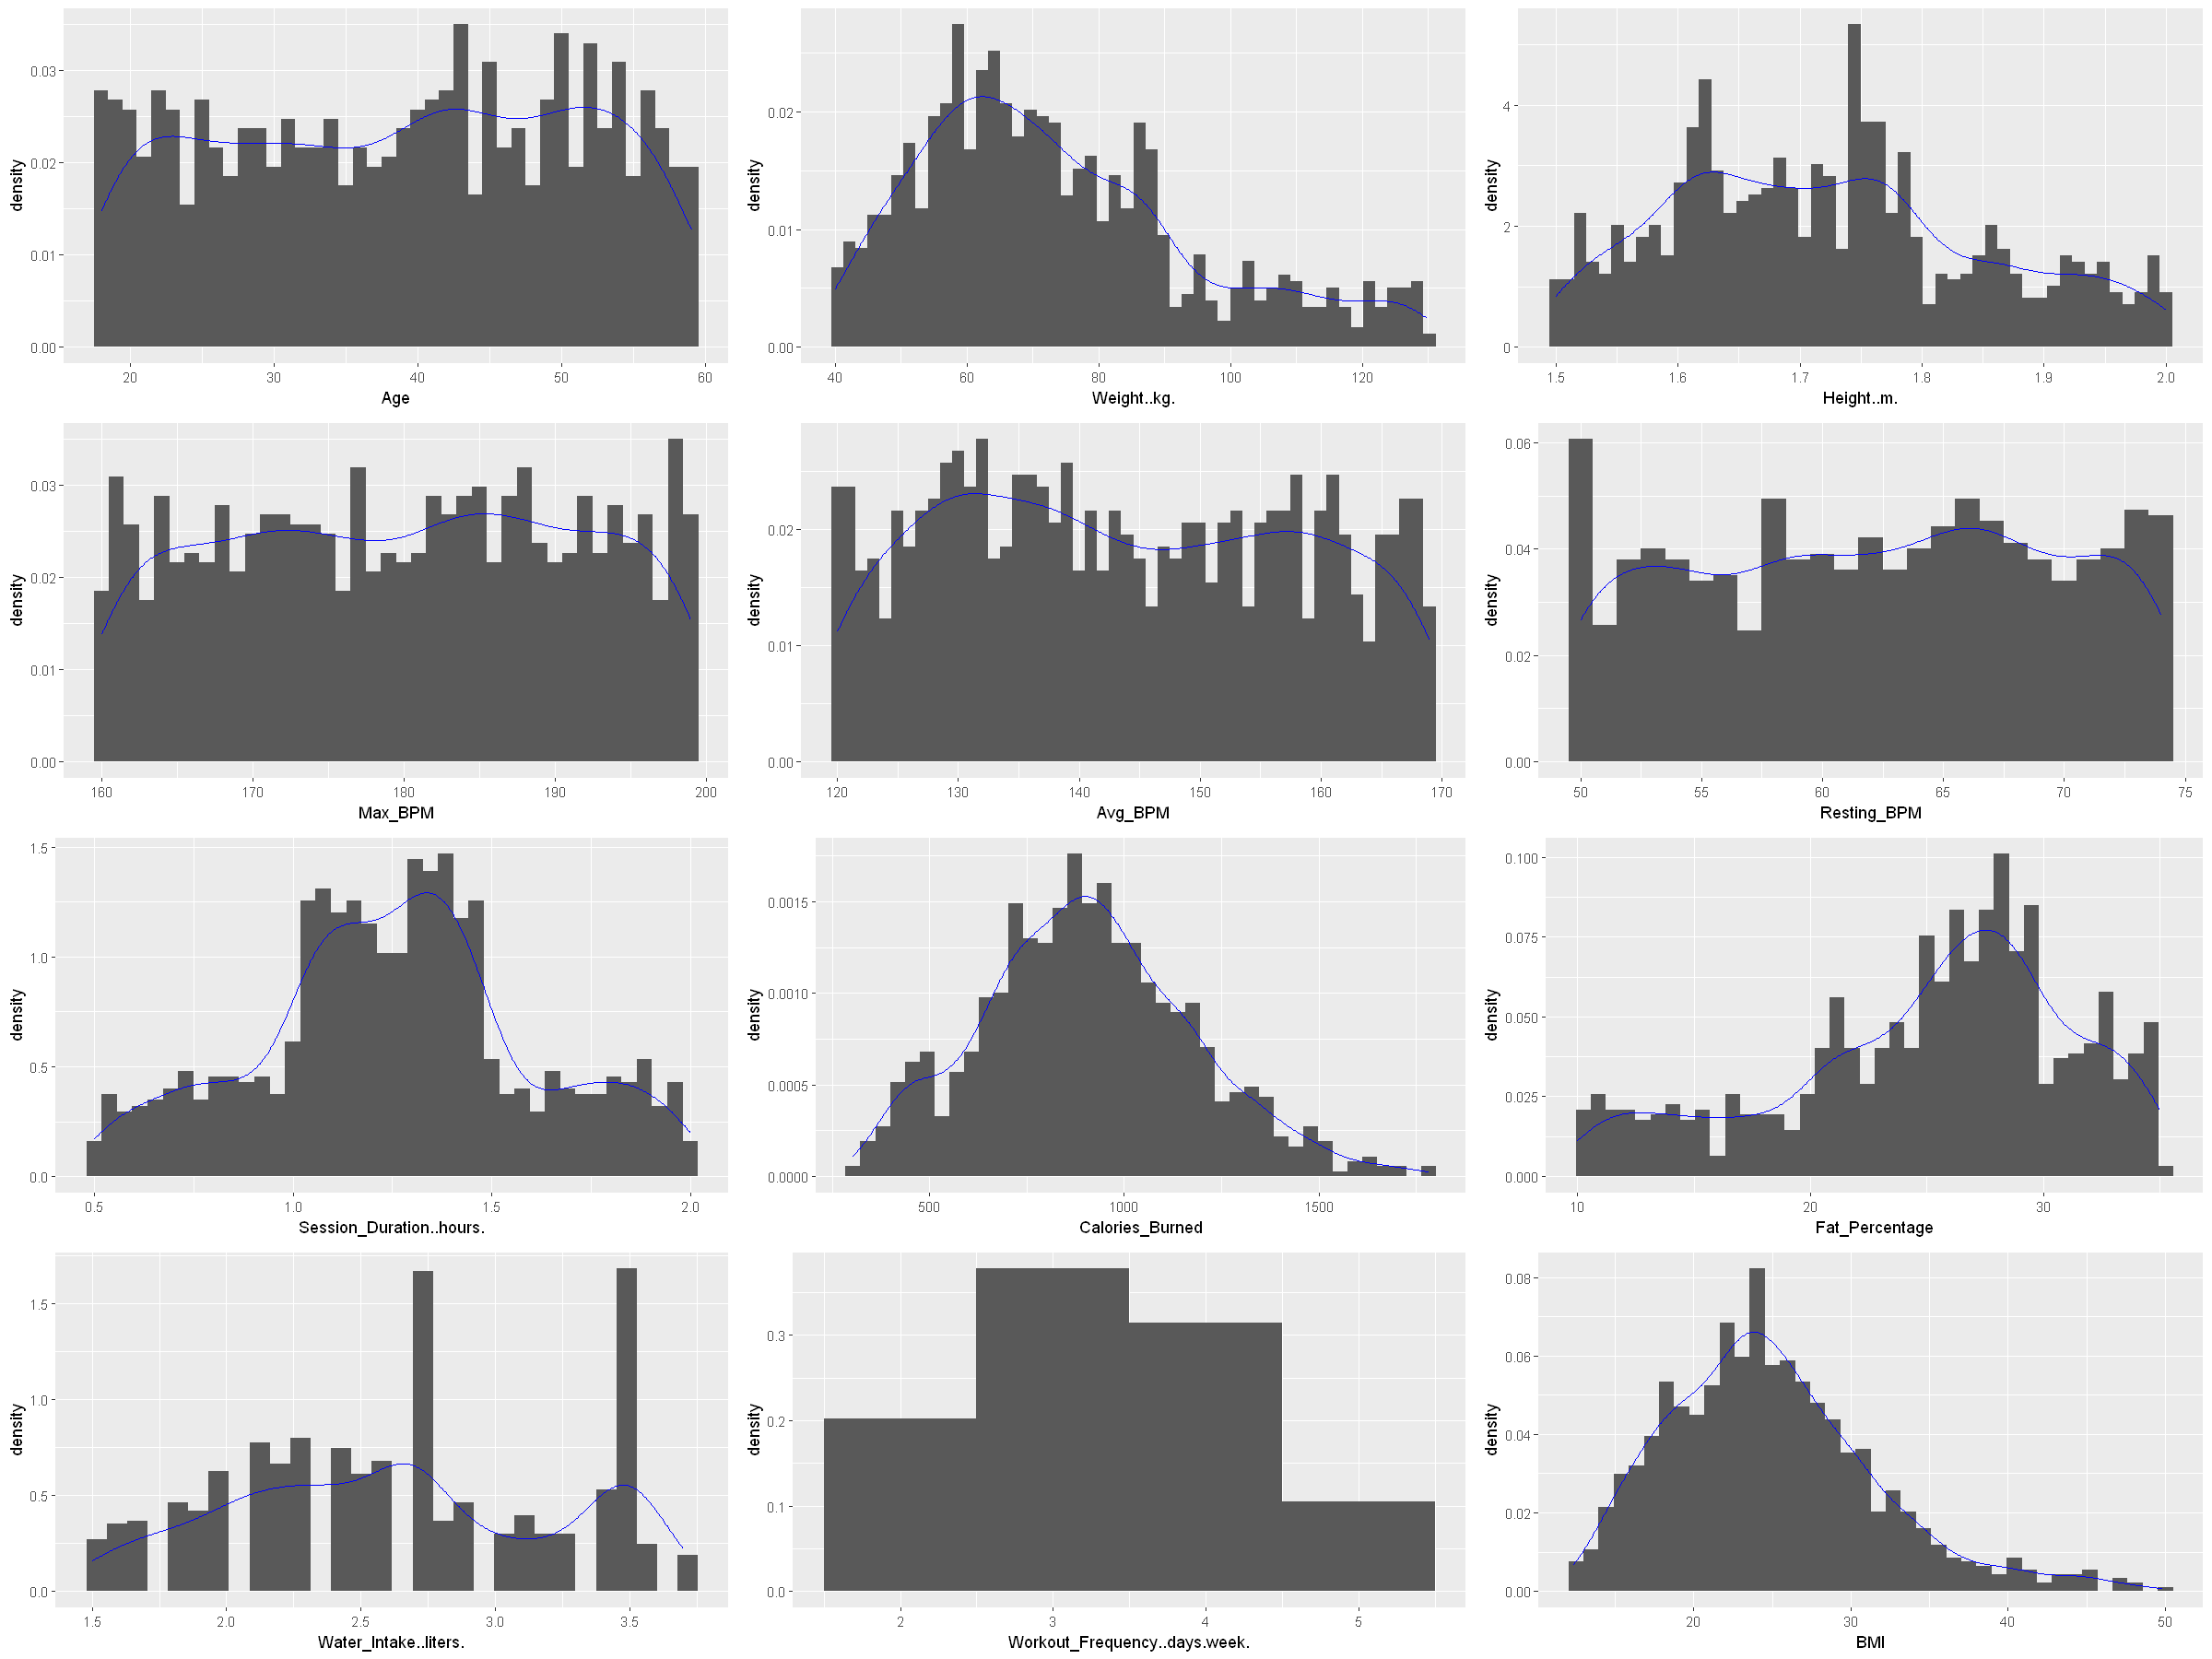

In [6]:
g1<-ggplot(gym,aes(x=Age))+geom_histogram(aes(y=..density..),bins=max(gym[,"Age"])-min(gym[,"Age"])+1)+geom_density(alpha=.2, col="blue") 
g2<-ggplot(gym,aes(x=Weight..kg.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g3<-ggplot(gym,aes(x=Height..m.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g4<-ggplot(gym,aes(x=Max_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Max_BPM"])-min(gym[,"Max_BPM"])+1)+geom_density(alpha=.2, col="blue") 
g5<-ggplot(gym,aes(x=Avg_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Avg_BPM"])-min(gym[,"Avg_BPM"])+1)+geom_density(alpha=.2, col="blue") 
g6<-ggplot(gym,aes(x=Resting_BPM))+geom_histogram(aes(y=..density..),bins=max(gym[,"Resting_BPM"])-min(gym[,"Resting_BPM"])+1)+geom_density(alpha=.2, col="blue")
g7<-ggplot(gym,aes(x=Session_Duration..hours.))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g8<-ggplot(gym,aes(x=Calories_Burned))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g9<-ggplot(gym,aes(x=Fat_Percentage))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")
g10<-ggplot(gym,aes(x=Water_Intake..liters.))+geom_histogram(aes(y=..density..),bins=30)+geom_density(alpha=.2, col="blue")
g11<-ggplot(gym,aes(x=Workout_Frequency..days.week.))+geom_histogram(aes(y=..density..),bins=4)
g12<-ggplot(gym,aes(x=BMI))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue")


options(repr.plot.width=20, repr.plot.height=15)
grid.arrange(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,ncol=3)

Analyse unidimensionnelle des variables quantitatives : 

- Age : répartition quasi-uniforme de la majorité à 60 ans
- Poids : répartition asymétrique (forme de courbe en chi-2) avec un pic aux alentours de 60kg
- Taille : répartition asymétrique, somme de deux gaussiennes, une centrée autour de 1m63 (correspondant aux femmes), et une centrée autour de 1m75 (correspondant aux hommes)
- BPM max : répartition quasi-uniforme de 160 à 200 bpm
- BPM moyen : répartition quasi-uniforme de 120 à 170 bpm
- BPM au repos : répartition quasi-uniforme de 50 à 75 bpm
- Durée de la session : répartition symétrique, similaire à une gaussienne ou une double gaussienne : on constate que les séances majoritaires sont celles entre 1h et 1h30
- Calories brûlées : répartition légèrement asymétrique, la majorité des séances brûlent moins que 1000 calories
- Pourcentage de masse graisseuse : répartition asymétrique, avec un pic autour de 27%
- Apport en eau : répartition asymétrique avec des pics aux alentours de 2.7L et 3.5L (en dehors de ces pics, on devine une gaussienne)
- Fréquence d'entraînement : la majorité des individus font 3 à 4 séances par semaine (sportifs réguliers)
- Indice de masse corporelle : répartition asymétrique (forme de courbe en chi-2) avec un pic aux alentours de 23

Analyse unidimensionnelle des variables qualitatives :

- un peu plus d'hommes que de femmes dans le jeu de données, mais ce n'est pas notable et pas suffisant pour que ça puisse biaiser nos résultats et conclusions.
- type d'entraînement : une répartition quasi-uniforme entre le cardio, l'entraînement fractionné de haute intensité (HIIT), la force athlétique et le yoga, on a donc tous types de profils.
- niveau d'expérience : majorité de personnes à niveaux 1 ou 2, le nombre de personnes de niveau 3 n'est pas négligeables bien que plus faible que les autres. Cela reflète la réalité de la population, il y a moins de personnes expérimentées qui vont à la salle de sport que de débutant ou intermédiaire. Cela ne devrait pas biaiser nos résultats d'analyse. 

On souhaite rendre les distributions asymétriques plus symétriques et "gaussiennes" pour pouvoir appliquer ensuite des techniques de modélisation linéaire. Pour cela, on teste des transformations  sur nos données et on retient celles qui donnent des résultats sensiblement plus symétriques que les distributions originelles. Ce sont les suivantes :

In [7]:
gym[,"LWeight..kg."] <- log((gym[,"Weight..kg."]))
gym[,"LBMI"] <- log((gym[,"BMI"]))
gym[,"Fat_Percentage_S"] <- ((gym[,"Fat_Percentage"])/100)**2
gym[,"SHeight..m."] <-sqrt(gym[,"Height..m."])
gym[,"LWater_Intake..liters."] <-log(gym[,"Water_Intake..liters."])

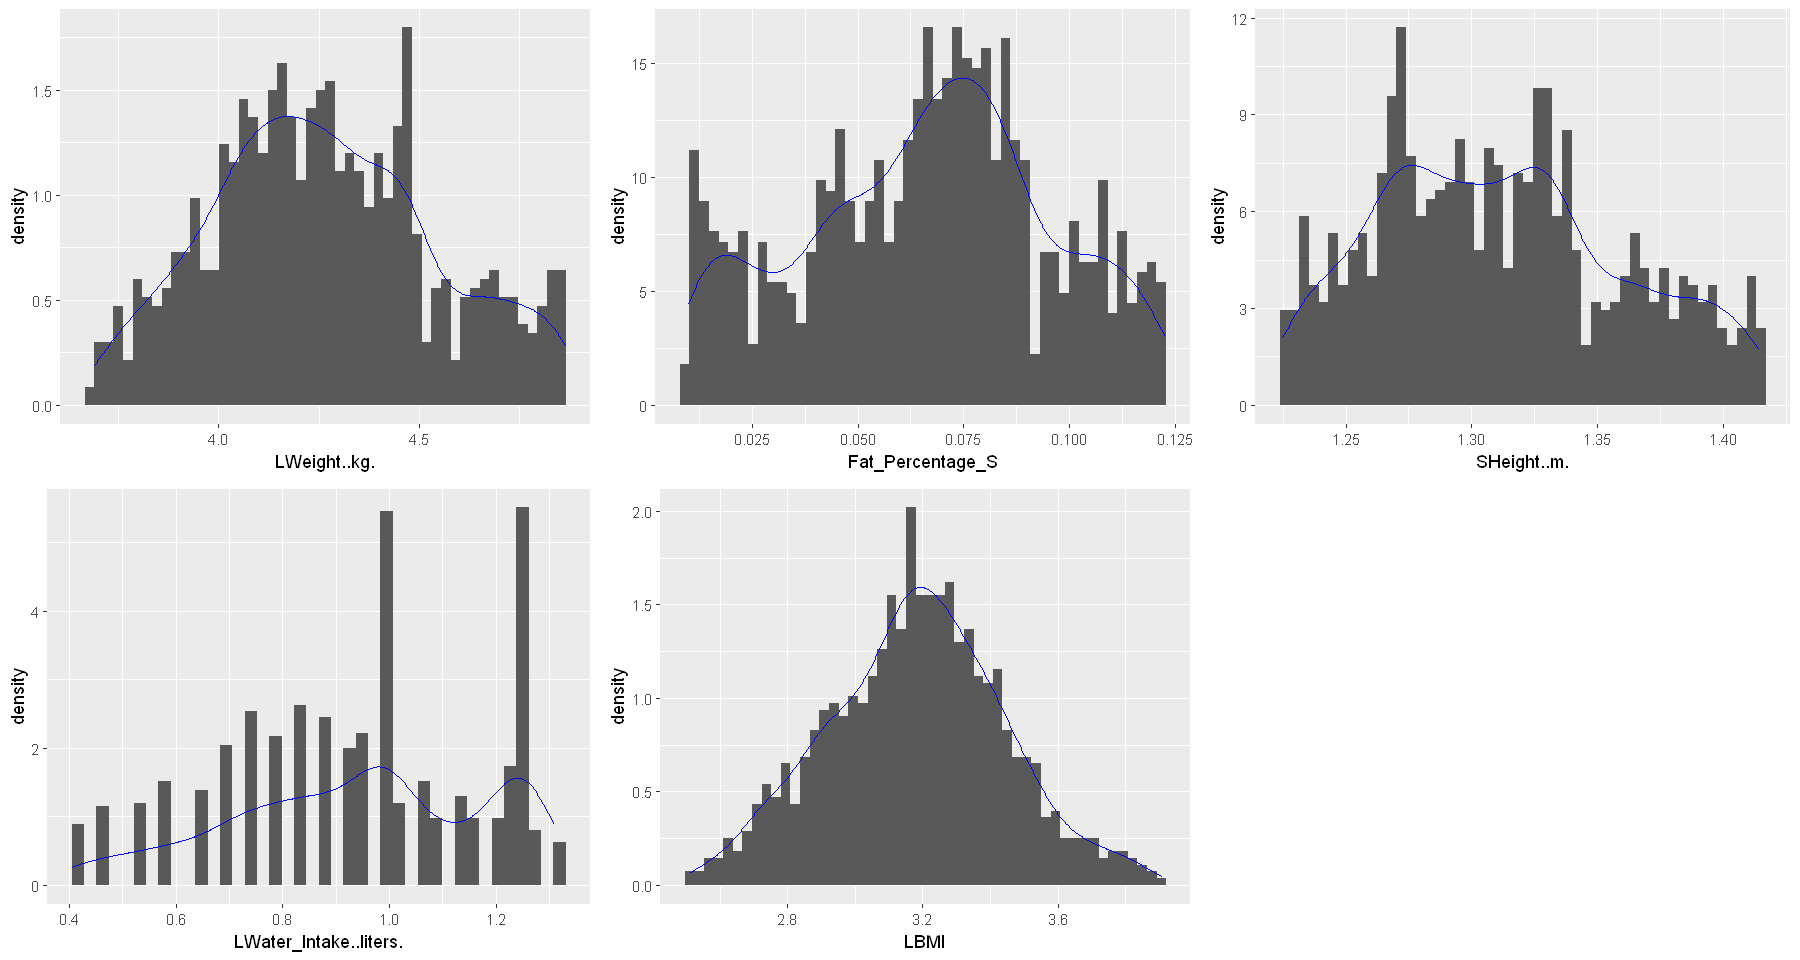

In [8]:
options(repr.plot.width=15, repr.plot.height=8)
g13<-ggplot(gym,aes(x=LWeight..kg.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g14<-ggplot(gym,aes(x=Fat_Percentage_S))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g15<-ggplot(gym,aes(x=SHeight..m.))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
g16<-ggplot(gym,aes(x=LWater_Intake..liters.))+geom_histogram(aes(y=..density..),bins=40)+geom_density(alpha=.2, col="blue") 
g17<-ggplot(gym,aes(x=LBMI))+geom_histogram(aes(y=..density..),bins=50)+geom_density(alpha=.2, col="blue") 
grid.arrange(g13,g14,g15,g16,g17,ncol=3)

On peut voir que pour certaines variables comme $BMI$ la transformation a permis de faire apparaître très distinctement la symétrie alors que pour d'autres le résultat est moins flagrant comme $Height$ mais toujours mieux que la variable de base. 

On va désormais retirer les variables initiales et conserver les variables transformées.

In [9]:
gym<-gym[,c(1:2,5:10,13:14,16:20)]
head(gym)

,Age,Gender,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Workout_Frequency..days.week.,Experience_Level,LWeight..kg.,LBMI,Fat_Percentage_S,SHeight..m.,LWater_Intake..liters.
,<int>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,Male,180,157,60,1.69,1313,Yoga,4,3,4.480740,3.407842,0.015876,1.307670,1.2527630
2,46,Female,179,151,66,1.30,883,HIIT,4,2,4.316154,3.465736,0.114921,1.236932,0.7419373
3,32,Female,167,122,54,1.11,677,Cardio,4,2,4.220977,3.207208,0.111556,1.288410,0.8329091
4,25,Male,190,164,56,0.59,532,Strength,3,1,3.974058,2.912894,0.082944,1.303840,0.7419373
5,38,Male,188,158,68,0.64,556,Strength,3,1,3.830813,2.666534,0.085264,1.337909,1.0296194
6,56,Female,168,156,74,1.59,1116,HIIT,5,3,4.060443,3.022861,0.024025,1.296148,0.9932518


### 4.Analyse Bidimensionelle

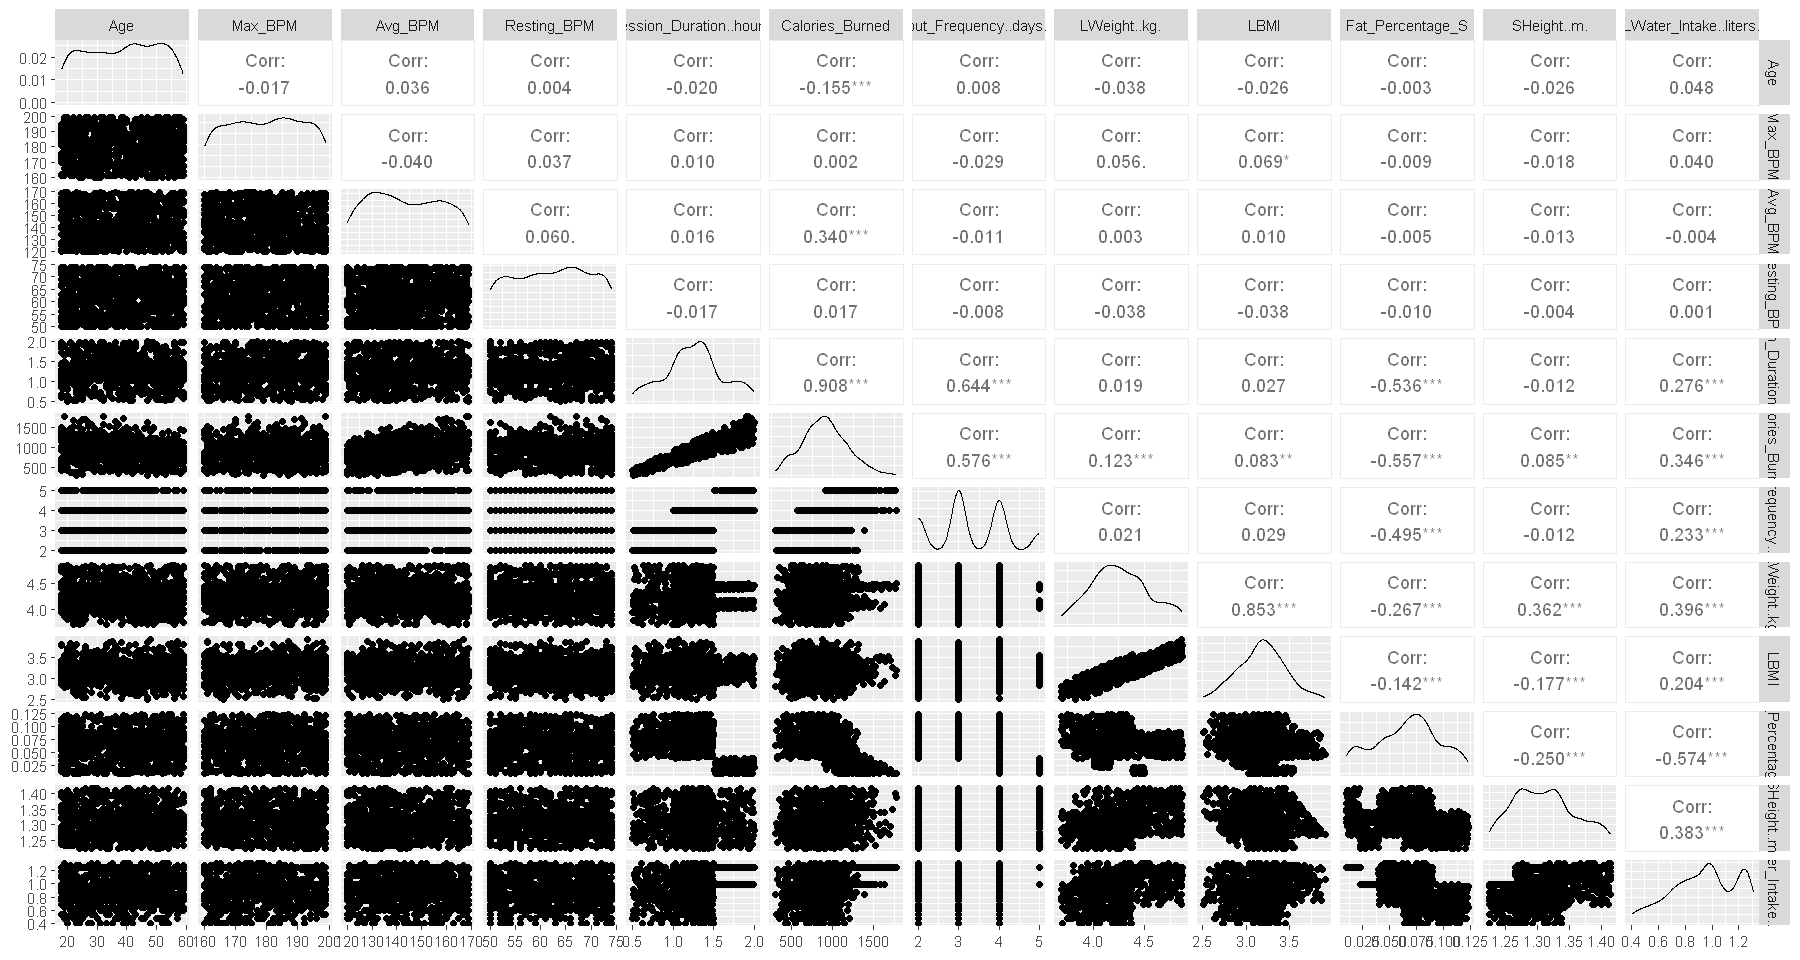

In [10]:
gym_num <- gym[, -c(2, 8, 10)]
ggpairs(gym_num)

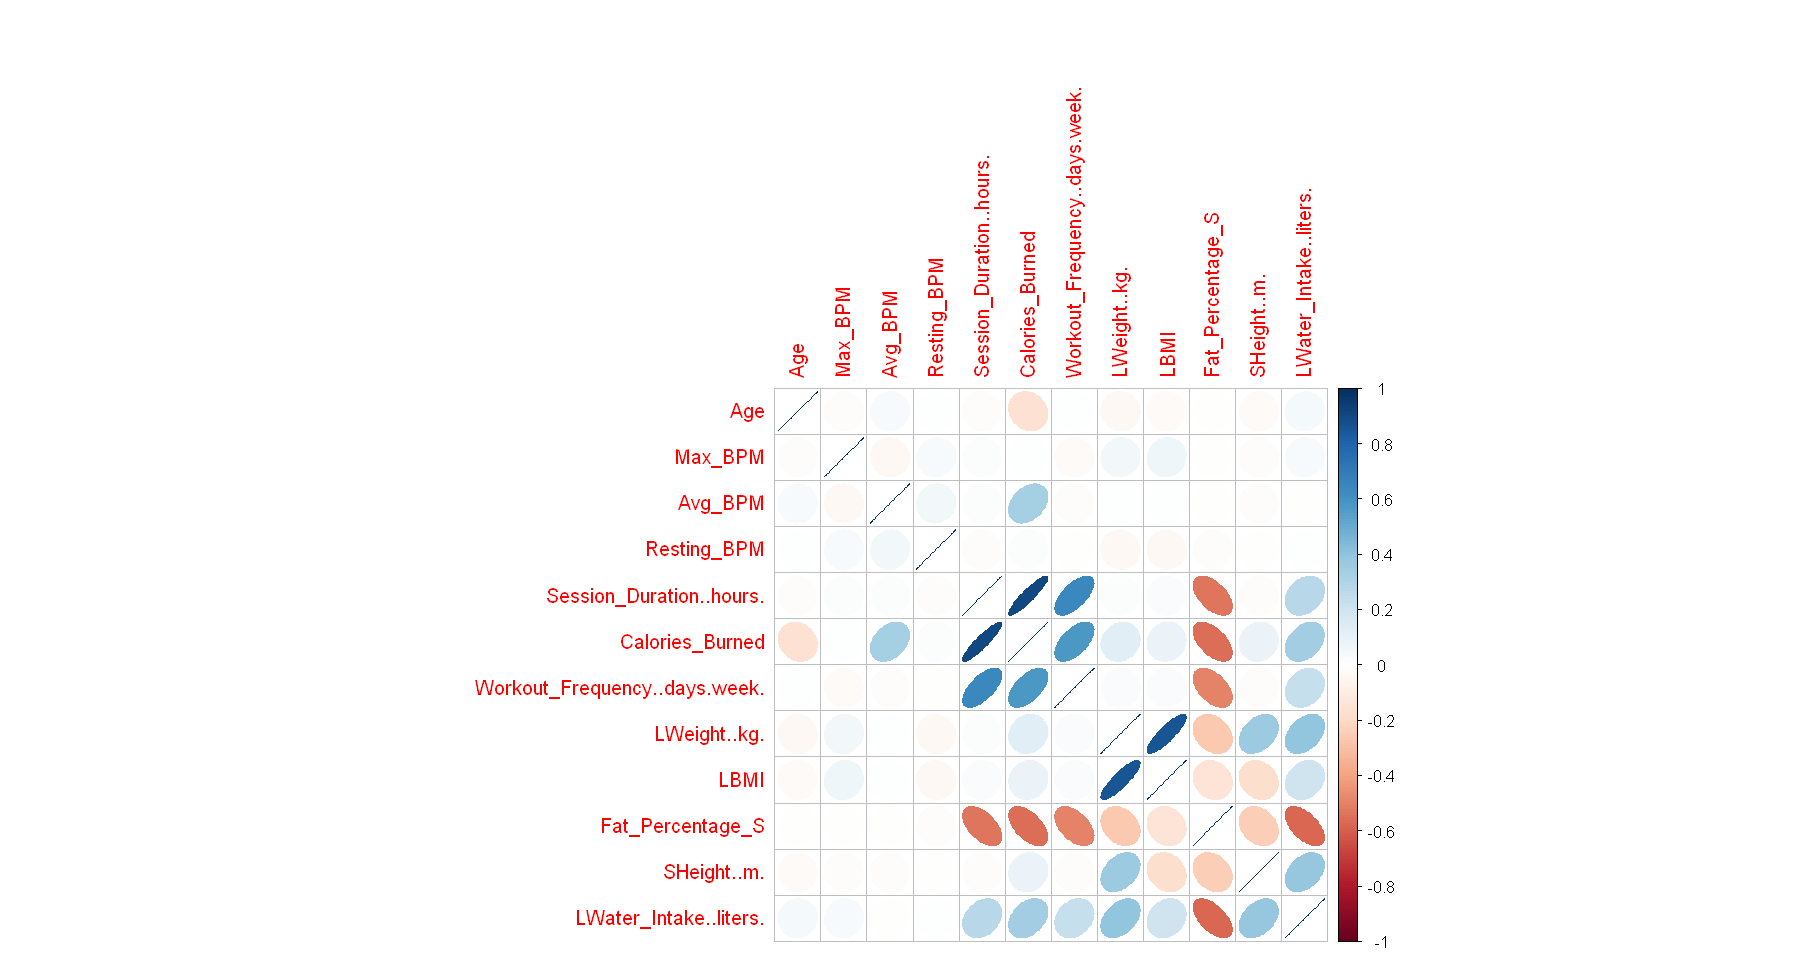

In [11]:
gym_num <- gym[, -c(2, 8, 10)]
corrplot(cor(gym_num), method="ellipse")


On remarque les corrélations significatives suivantes :

- les individus qui font des sessions plus longues brûlent davantage de calories par session (ce qui est cohérent), une relation linéaire semble en effet se dessiner entre ces deux variables
- les individus qui font des sessions plus longues ont tendance à avoir des pourcentages de masse graisseuse plus bas
- les individus qui font des sessions plus longues ont tendance à faire des séances plus souvent
- les individus qui brûlent beaucoup de calories par session ont tendance à avoir des pourcentages de masse graisseuse plus bas
- les individus qui brûlent beaucoup de calories par session ont tendance à faire des séances plus souvent
- les individus qui ont des pourcentages de masse graisseuse plus bas consomment davantage d'eau (ce qui est surprenant dans une certaine mesure!)
- les individus qui ont des pourcentages de masse graisseuse plus bas ont tendance à faire des séances plus souvent (cohérent)
- plus les individus sont lourds, plus leur IMC a tendance à être elevé (ce qui est cohérent car c'est l'un des facteurs rentrant dans le calcul de l'IMC), on observe en effet une relation linéaire entre le log de ces deux variables, ce qui est cohérent car IMC=masse/taille**2

## ACP

On cherche à prédire le nombre de calories brulée en fonction des autres variables, on les retire donc pour réaliser l'ACP

In [28]:
# ACP réduite
acp <- PCA(gym[,-7], scale.unit = TRUE,
           graph = FALSE, quali.sup = c(2,7,9), ncp=7)


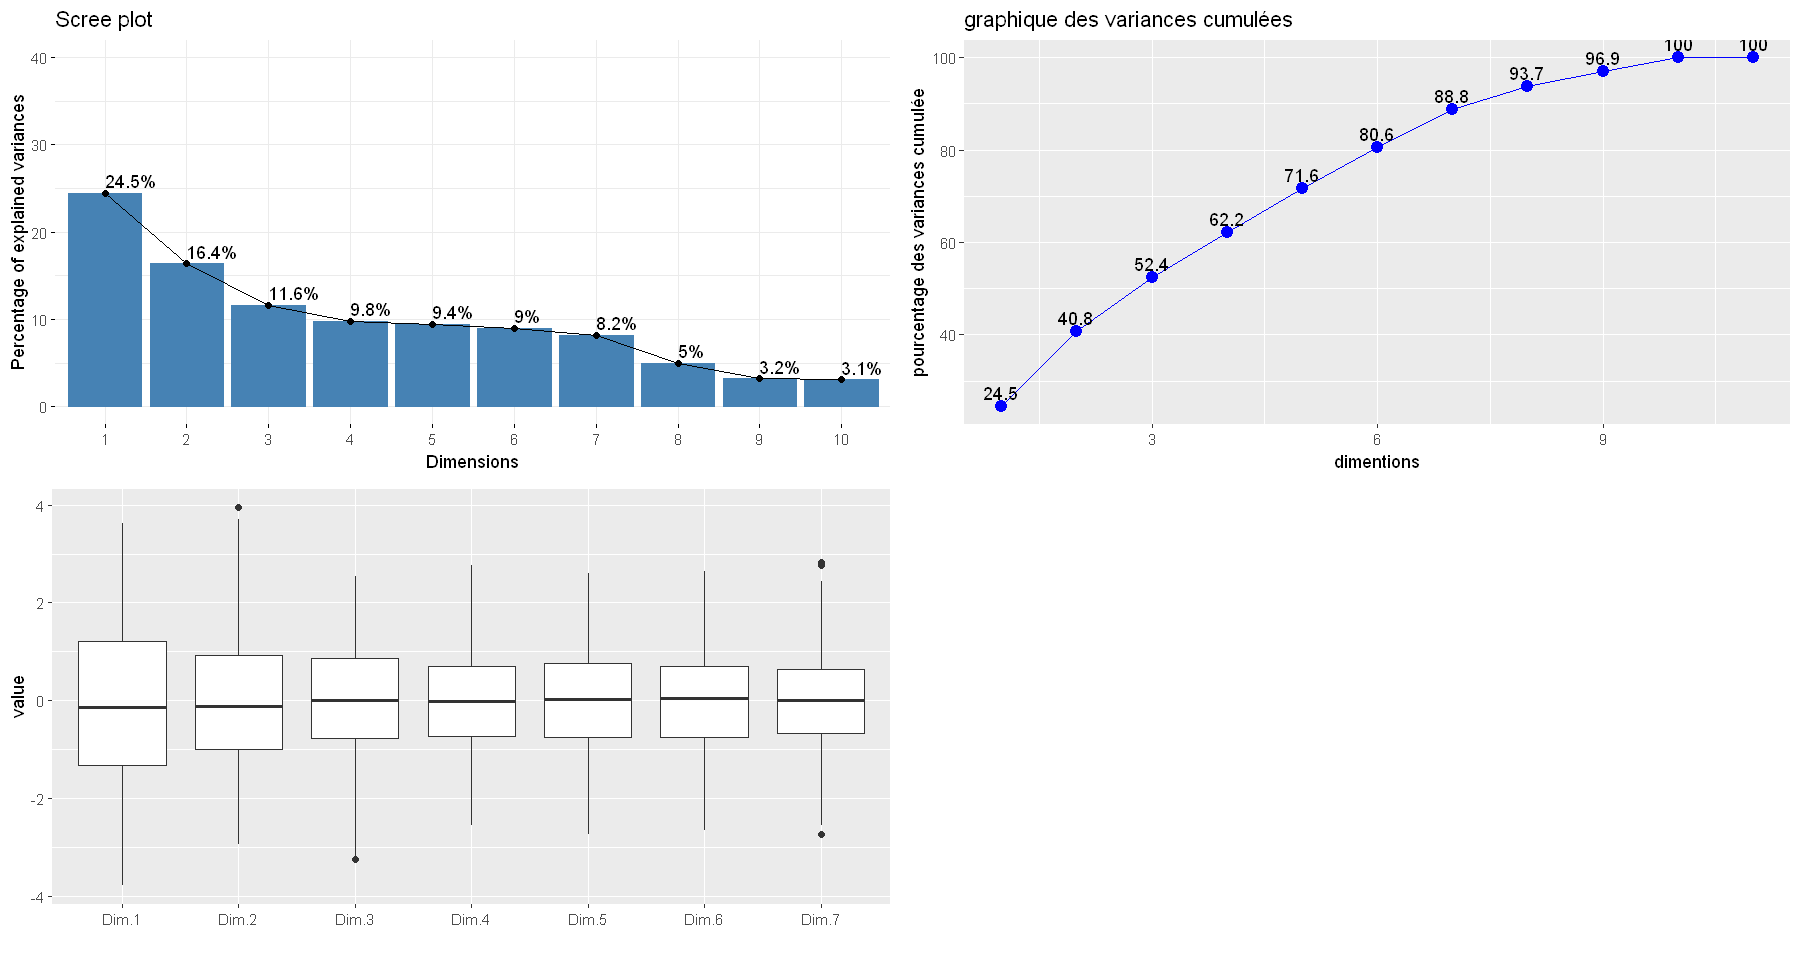

In [29]:
# Décroissance des valeurs propres
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))

#variance cumulées 
cum_var <- cumsum(acp$eig[, 2]) 

# Graphique avec ggplot2
g2<-ggplot(data.frame(Dimension = 1:length(cum_var), Variance = cum_var), aes(x = Dimension, y = Variance)) +
    geom_point(size = 3, color = "blue") +
    geom_line(color = "blue") +
    labs(title = "graphique des variances cumulées",x='dimentions', y = "pourcentage des variances cumulée") +
    geom_text(aes(y = cum_var, label = round(cum_var, 1)), vjust = -0.5, color = "black") 

g3<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,g3,ncol=2)

On choisit de garder les trois premières dimensions car on observe une faible diminution du pourcentage d'explication des dimentions par la variance à partir de la troisième dimension (coude sur la figure 1). On aurait pu aussi choisir de garder six dimentions pour atteindre plus de 80% de l'explication des variances cumulées. Cependant le second choix aurait conduit à peu réduire la dimention de notre analyse.

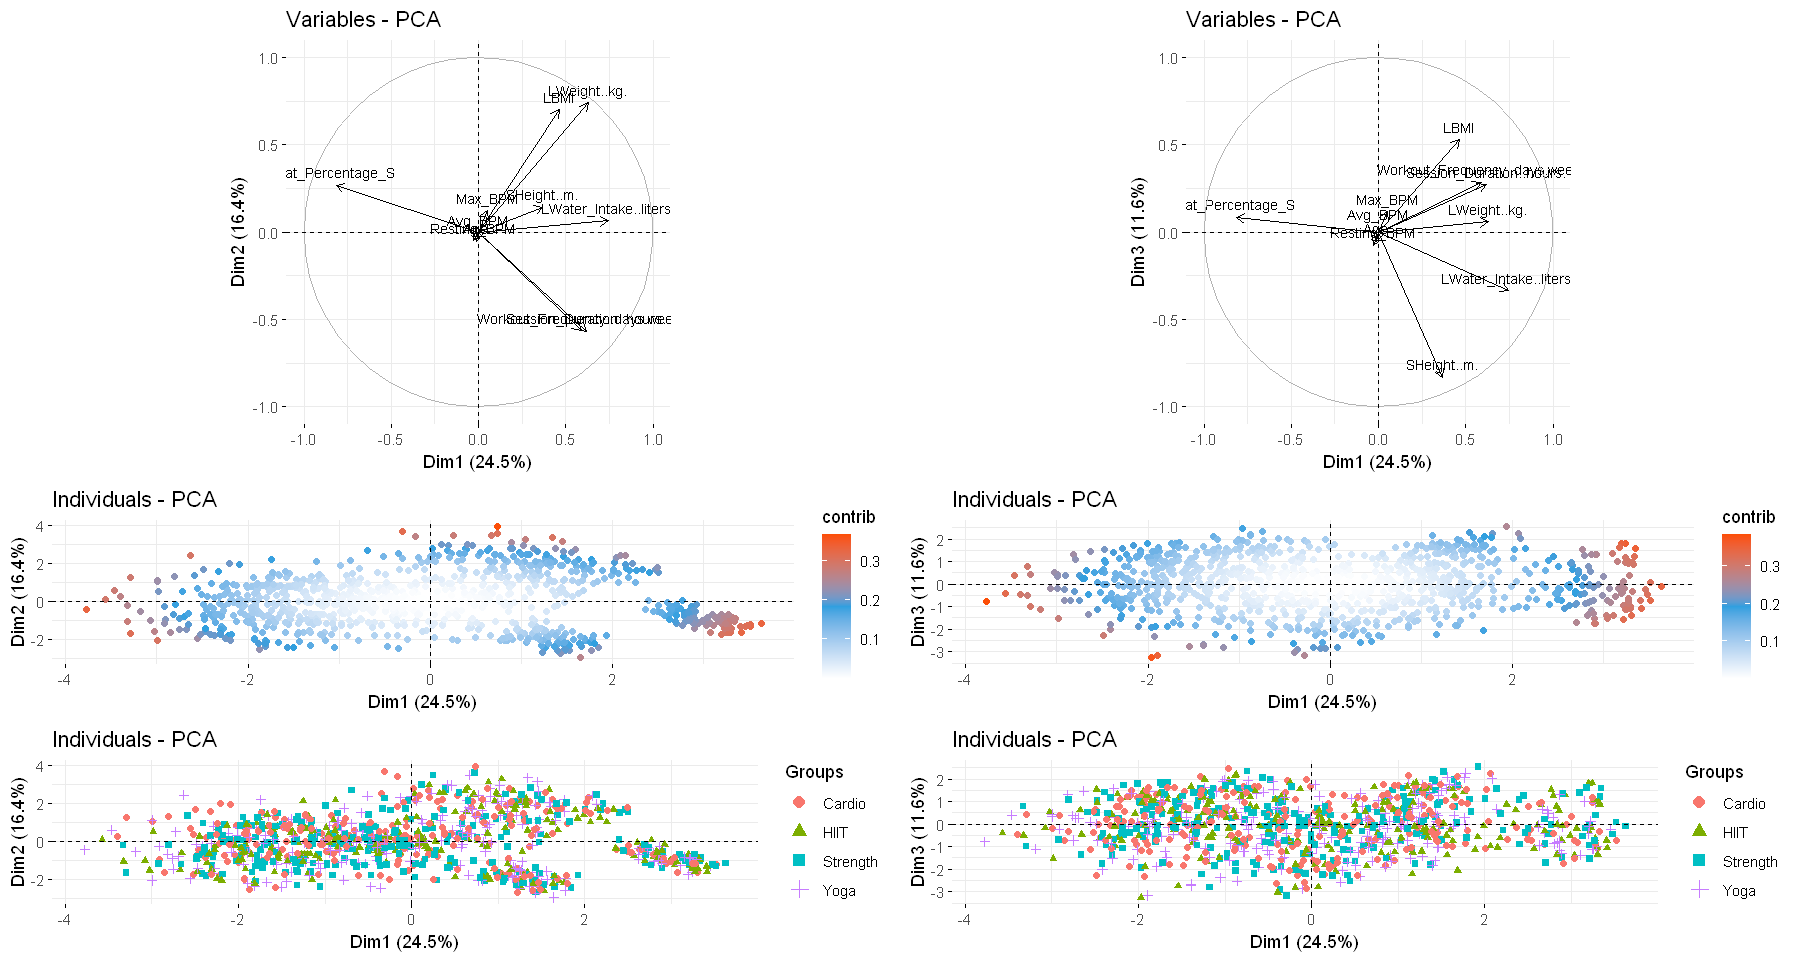

In [43]:
g4<-fviz_pca_var(acp,labelsize = 3)
g5<-fviz_pca_ind(acp, col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
g6<-fviz_pca_var(acp,axes=c(1,3),labelsize = 3)
g7<-fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

grid.arrange(g4,g6,g5,g7,g8,g9,ncol=2,nrow=3,heights=c(2,1,1))

Il semble difficile d'expliciter ce que pourraient représenter les dimensions.

On effectue une seconde acp avec le nombre de calories brulées dans le but de prédire le niveau d'expérience.

In [31]:
acp_level <- PCA(gym, scale.unit = TRUE,
           graph = FALSE, quali.sup = c(2,8,10), ncp=7)

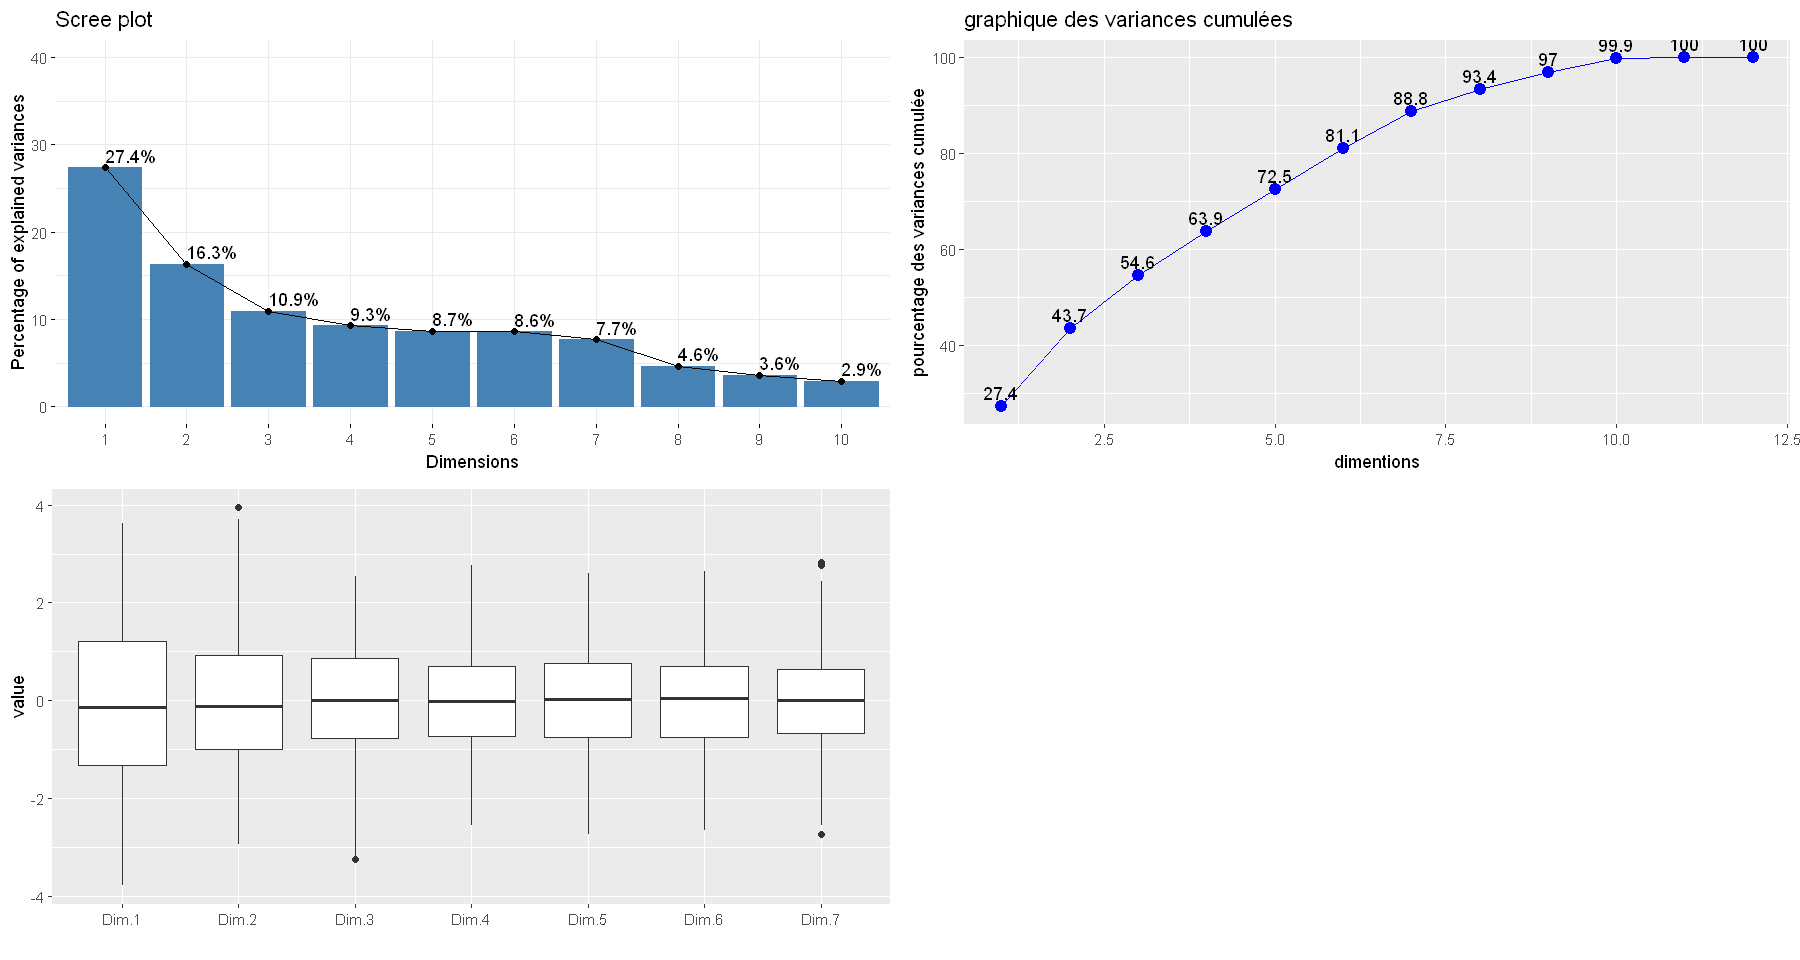

In [32]:
# Décroissance des valeurs propres
g1<-fviz_eig(acp_level, addlabels = TRUE, ylim = c(0, 40))

#variance cumulées 
cum_var <- cumsum(acp_level$eig[, 2]) 

# Graphique avec ggplot2
g2<-ggplot(data.frame(Dimension = 1:length(cum_var), Variance = cum_var), aes(x = Dimension, y = Variance)) +
    geom_point(size = 3, color = "blue") +
    geom_line(color = "blue") +
    labs(title = "graphique des variances cumulées",x='dimentions', y = "pourcentage des variances cumulée") +
    geom_text(aes(y = cum_var, label = round(cum_var, 1)), vjust = -0.5, color = "black") 

g3<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,g3,ncol=2)

Comme précédement on observe un coude à la troisième dimension 

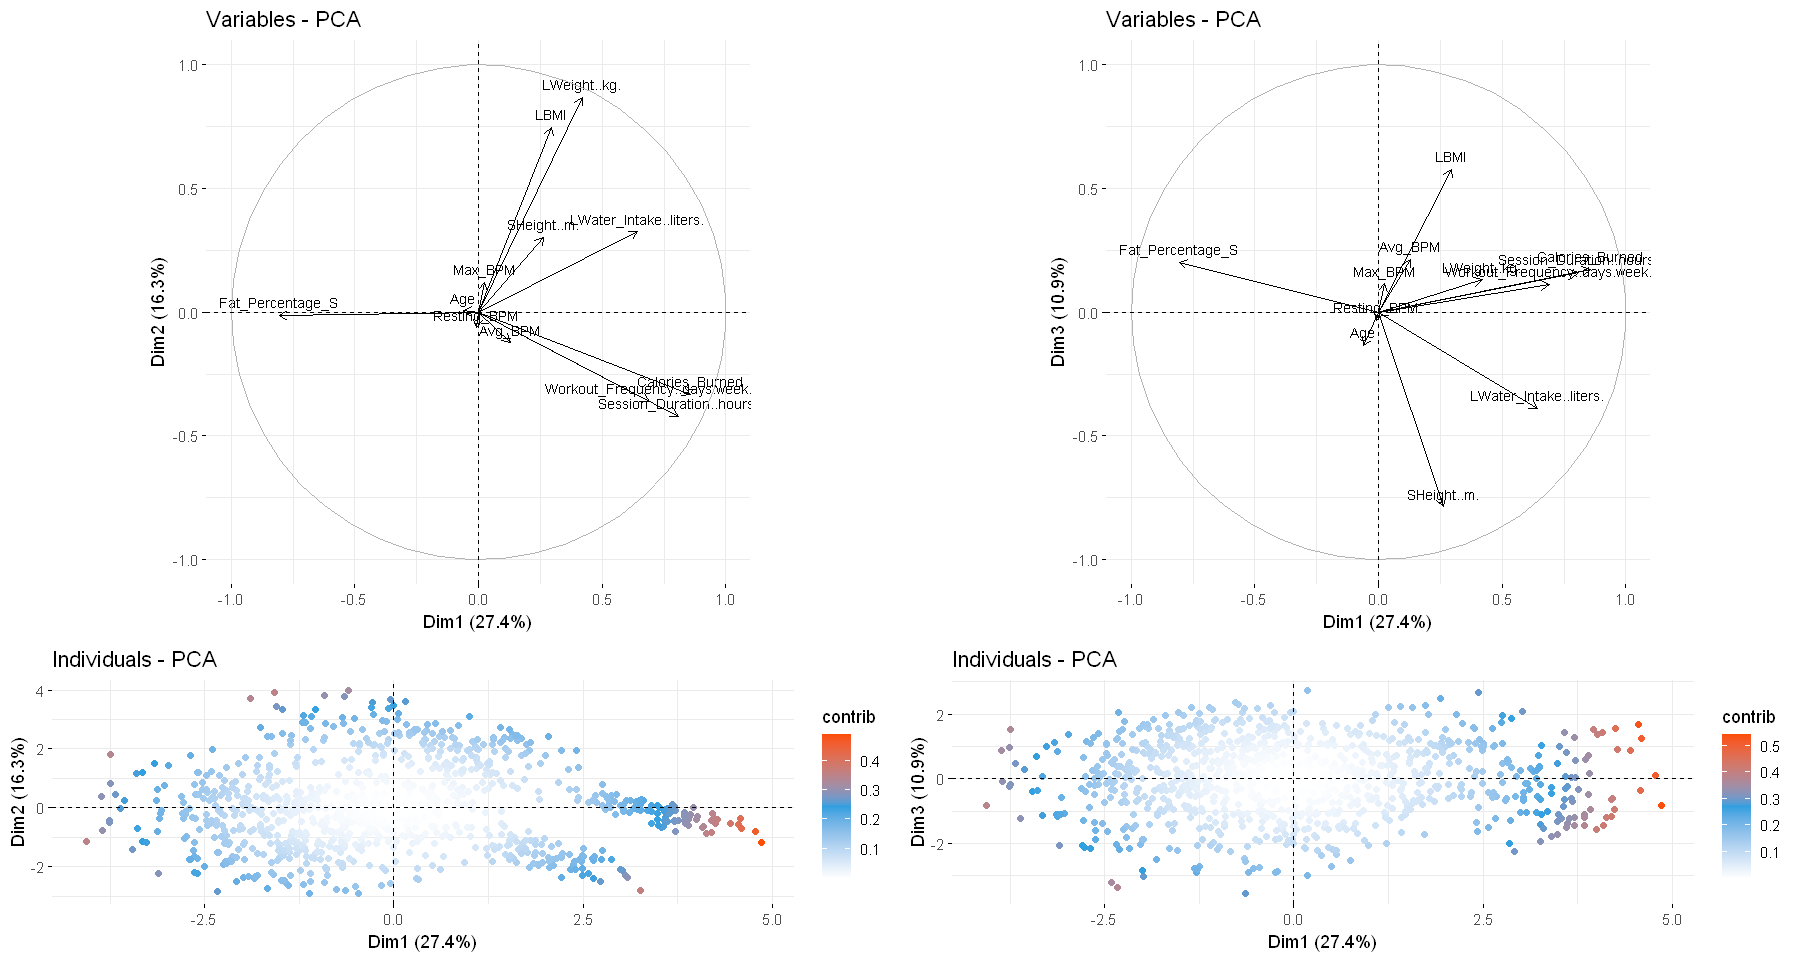

In [33]:
g4<-fviz_pca_var(acp_level,labelsize = 3)
g5<-fviz_pca_ind(acp_level, col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
g6<-fviz_pca_var(acp_level,axes=c(1,3),labelsize = 3)
g7<-fviz_pca_ind(acp_level,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

grid.arrange(g4,g6,g5,g7,ncol=2,heights=c(2,1))

dimension aussi compliquées à expliquer
Quelques individus ont une contributions plus forte aux axes 2 et 3 mais pas signification abérante, il peut s'agir de personneaux séances plus intenses

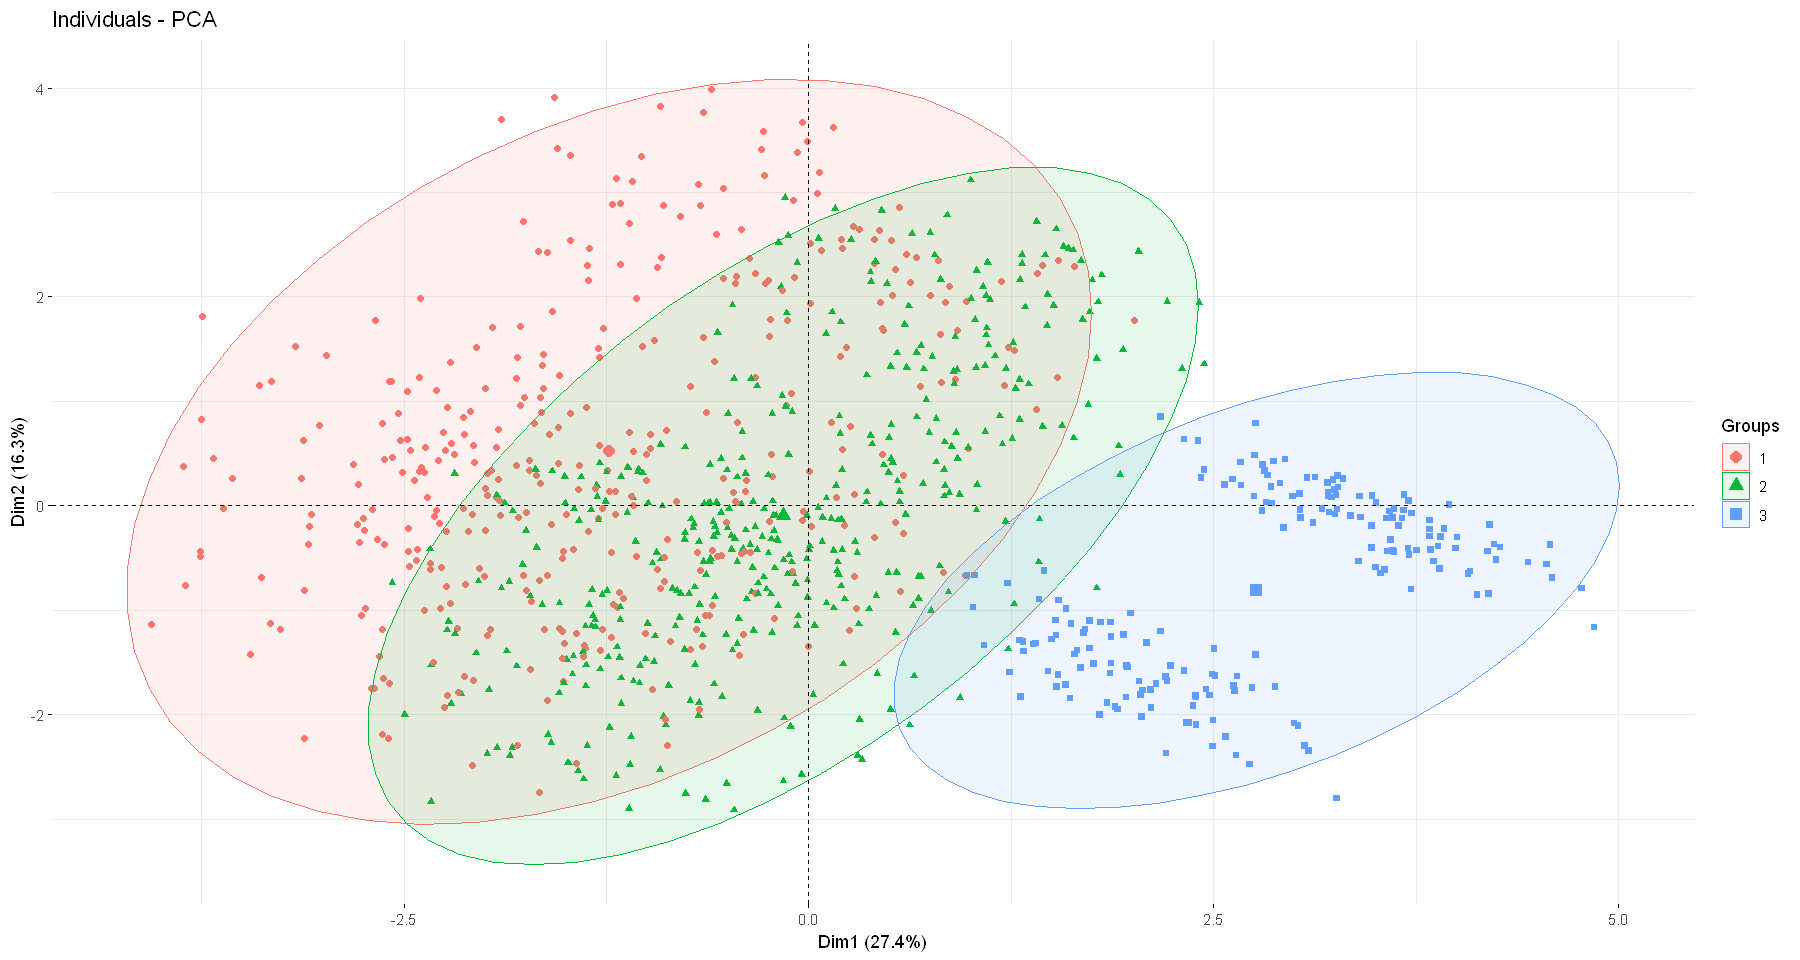

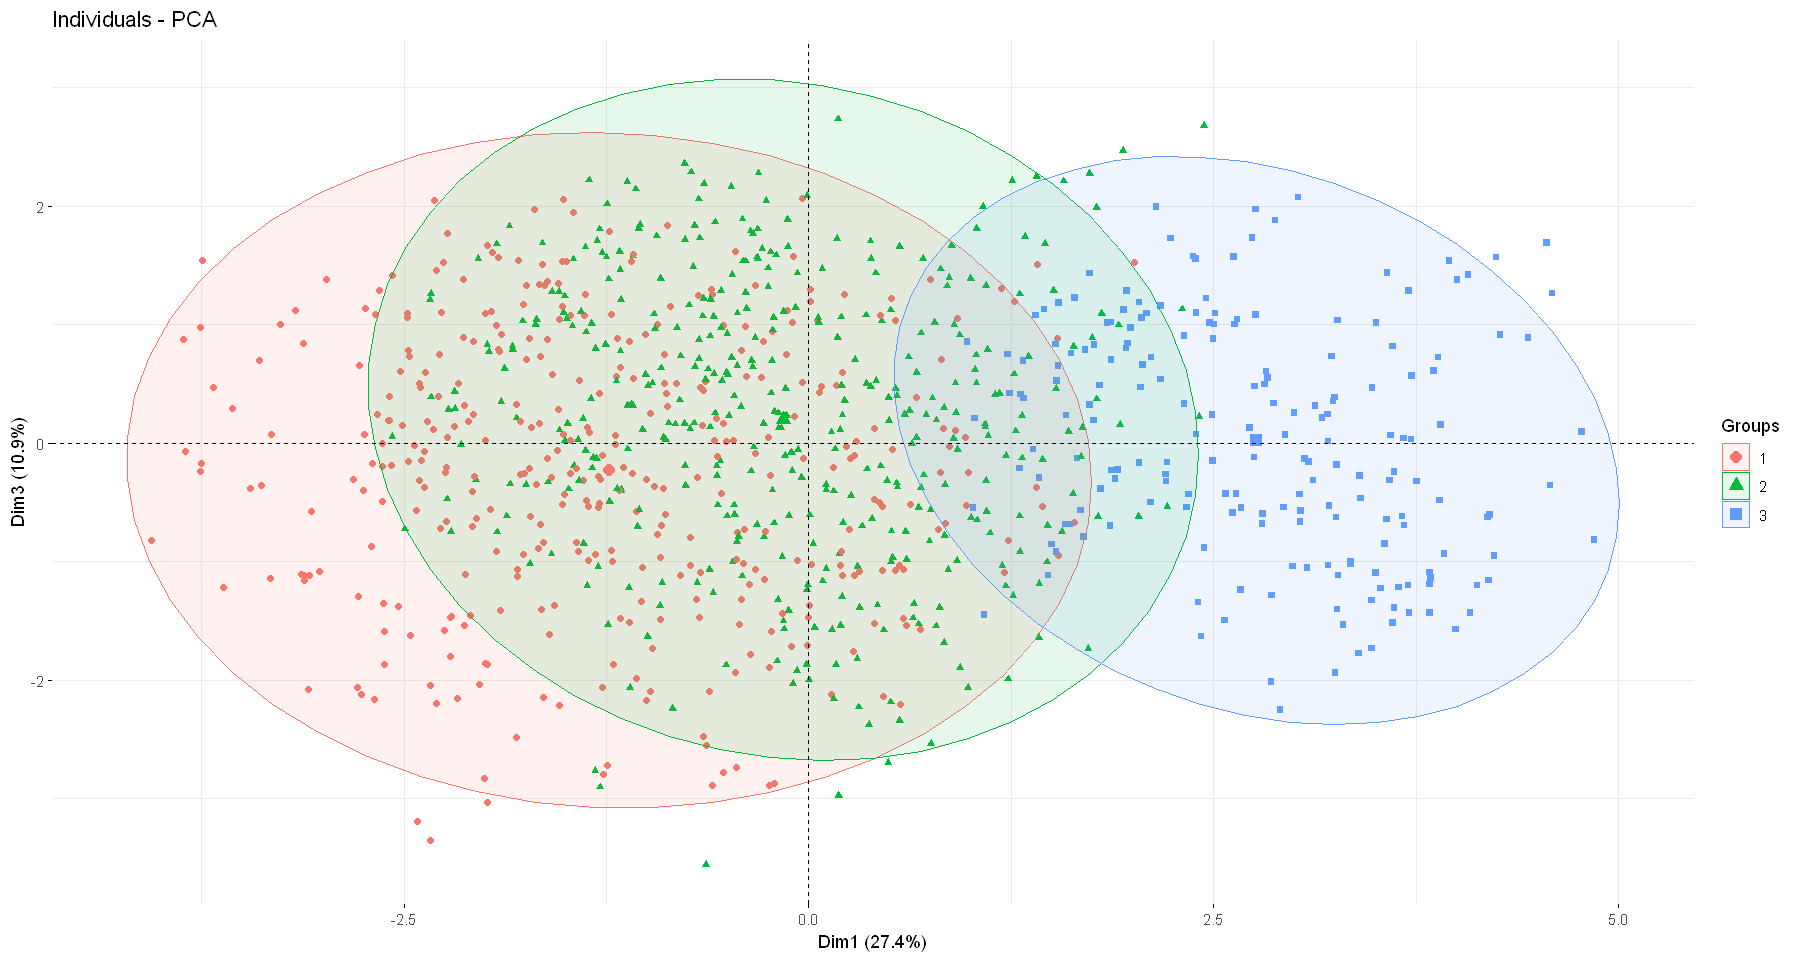

In [36]:
g8<-fviz_pca_ind(acp_level, habillage=gym$Experience_Level,label="none",addEllipses=TRUE, ellipse.level=0.95)
g9<-fviz_pca_ind(acp_level,habillage=gym$Experience_Level,label="none",axes=c(1,3),addEllipses=TRUE, ellipse.level=0.95)
g8
g9

Dans le plan factoriel des dimensions 1 et 2 on voit se distinguer les individus les plus expériementé. Les individus moyennement expérimentés sont quand à eux complètement confondus avec les individus peu expériementés dans le deux plans factoriels.